# Market Basket Analysis

### About Dataset

**Market basket analysis with Apriori algorithm**

The retailer wants to target customers with suggestions on itemset that a customer is most likely to purchase .I was given dataset contains data of a retailer; the transaction data provides data around all the transactions that have happened over a period of time. Retailer will use result to grove in his industry and provide for customer suggestions on itemset, we be able increase customer engagement and improve customer experience and identify customer behavior. I will solve this problem with use Association Rules type of unsupervised learning technique that checks for the dependency of one data item on another data item.

**Introduction**<br>
Association Rule is most used when you are planning to build association in different objects in a set. It works when you are planning to find frequent patterns in a transaction database. It can tell you what items do customers frequently buy together and it allows retailer to identify relationships between the items.

**An Example of Association Rules**<br>
Assume there are 100 customers, 10 of them bought Computer Mouth, 9 bought Mat for Mouse and 8 bought both of them.

bought Computer Mouth => bought Mat for Mouse
support = P(Mouth & Mat) = 8/100 = 0.08
confidence = support/P(Mat for Mouse) = 0.08/0.09 = 0.89
lift = confidence/P(Computer Mouth) = 0.89/0.10 = 8.9
This just simple example. In practice, a rule needs the support of several hundred transactions, before it can be considered statistically significant, and datasets often contain thousands or millions of transactions.


### Dataset Description<br>
File name: Assignment-1_Data<br>

List name: retaildata<br>

File format: . csv<br>

Number of Row: 522065<br>

Number of Attributes: 7<br>

BillNo: 6-digit number assigned to each transaction. Nominal.<br>
Itemname: Product name. Nominal.<br>
Quantity: The quantities of each product per transaction. Numeric.<br>
Date: The day and time when each transaction was generated. Numeric.<br>
Price: Product price. Numeric.<br>
CustomerID: 5-digit number assigned to each customer. Nominal.<br>
Country: Name of the country where each customer resides. Nominal.<br>


### Import Librabries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
import numpy as np

In [32]:
# Configuration of Spark Session
spark = SparkSession.builder.\
master("local[*]").\
appName("Market Basket Analysis").\
getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Market Basket Analysis>

### Data preparation

In [3]:
Market_df = spark.read.csv('/home/hduser/jupyterProjects/Pyspark/Apriori_Algorithm/data/Assignment-1_Data.csv', 
                           header='true', inferSchema='true', sep=';')

In [4]:
Market_df.show(6)

+------+--------------------+--------+----------------+-----+----------+--------------+
|BillNo|            Itemname|Quantity|            Date|Price|CustomerID|       Country|
+------+--------------------+--------+----------------+-----+----------+--------------+
|536365|WHITE HANGING HEA...|       6|01.12.2010 08:26| 2,55|     17850|United Kingdom|
|536365| WHITE METAL LANTERN|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|CREAM CUPID HEART...|       8|01.12.2010 08:26| 2,75|     17850|United Kingdom|
|536365|KNITTED UNION FLA...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|RED WOOLLY HOTTIE...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|SET 7 BABUSHKA NE...|       2|01.12.2010 08:26| 7,65|     17850|United Kingdom|
+------+--------------------+--------+----------------+-----+----------+--------------+
only showing top 6 rows



In [5]:
Market_df.printSchema()

root
 |-- BillNo: string (nullable = true)
 |-- Itemname: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [6]:
Market_df.summary().show()

+-------+------------------+--------------------+------------------+----------------+------------------+------------------+-----------+
|summary|            BillNo|            Itemname|          Quantity|            Date|             Price|        CustomerID|    Country|
+-------+------------------+--------------------+------------------+----------------+------------------+------------------+-----------+
|  count|            522064|              520609|            522064|          522064|            522064|            388023|     522064|
|   mean| 559950.7852856276|                null|10.090435272303779|            null|15.576812289966394|15316.931710233672|       null|
| stddev|13452.750899843604|                null|  161.110525182291|            null|  72.6216939005565|1721.8469642664186|       null|
|    min|            536365|"ASSORTED FLOWER ...|             -9600|01.02.2011 08:23|         -11062,06|             12346|  Australia|
|    25%|          547890.0|                null

filling missing CustomerID with 999999

In [7]:
df_market = Market_df.fillna(99999, subset='CustomerID')

In [8]:
summary = df_market.describe().toPandas()

In [9]:
summary

,summary,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,count,522064,520609,522064,522064,522064,522064,522064
1,mean,559950.7852856276,None,10.090435272303779,None,15.576812289966394,37059.22597995648,None
2,stddev,13452.750899843604,None,161.110525182291,None,72.6216939005565,37022.44261731424,None
3,min,536365,"""ASSORTED FLOWER COLOUR """"LEIS""""""",-9600,01.02.2011 08:23,"-11062,06",12346,Australia
4,max,A563187,wrongly sold sets,80995,31.10.2011 17:19,"99,96",99999,Unspecified


In [10]:
df_market[['Itemname']].distinct().count()

4186

In [11]:
df_market[['Country']].distinct().show(100)

+--------------------+
|             Country|
+--------------------+
|              Sweden|
|           Singapore|
|             Germany|
|                 RSA|
|              France|
|              Greece|
|             Belgium|
|               Malta|
|         Unspecified|
|               Italy|
|           Lithuania|
|              Norway|
|               Spain|
|           Hong Kong|
|             Iceland|
|              Israel|
|                 USA|
|        Saudi Arabia|
|         Switzerland|
|United Arab Emirates|
|              Brazil|
|             Lebanon|
|               Japan|
|              Poland|
|            Portugal|
|           Australia|
|             Austria|
|             Bahrain|
|      United Kingdom|
|         Netherlands|
+--------------------+



In [12]:
df_market.filter(df_market.Itemname=='WHITE HANGING HEART T-LIGHT HOLDER').show(truncate=False)

+------+----------------------------------+--------+----------------+-----+----------+--------------+
|BillNo|Itemname                          |Quantity|Date            |Price|CustomerID|Country       |
+------+----------------------------------+--------+----------------+-----+----------+--------------+
|536365|WHITE HANGING HEART T-LIGHT HOLDER|6       |01.12.2010 08:26|2,55 |17850     |United Kingdom|
|536373|WHITE HANGING HEART T-LIGHT HOLDER|6       |01.12.2010 09:02|2,55 |17850     |United Kingdom|
|536375|WHITE HANGING HEART T-LIGHT HOLDER|6       |01.12.2010 09:32|2,55 |17850     |United Kingdom|
|536390|WHITE HANGING HEART T-LIGHT HOLDER|64      |01.12.2010 10:19|2,55 |17511     |United Kingdom|
|536394|WHITE HANGING HEART T-LIGHT HOLDER|32      |01.12.2010 10:39|2,55 |13408     |United Kingdom|
|536396|WHITE HANGING HEART T-LIGHT HOLDER|6       |01.12.2010 10:51|2,55 |17850     |United Kingdom|
|536401|WHITE HANGING HEART T-LIGHT HOLDER|4       |01.12.2010 11:21|2,95 |15862  

We see that the Price is referred to a single product

In [13]:
df_market = df_market.filter(df_market.Quantity>0)

Check total null of each column.

In [14]:
df_market.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_market.columns]).show()

+------+--------+--------+----+-----+----------+-------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|
+------+--------+--------+----+-----+----------+-------+
|     0|     592|       0|   0|    0|         0|      0|
+------+--------+--------+----+-----+----------+-------+



In [15]:
df_market = df_market.dropna()

In [16]:
df_market.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_market.columns]).show()

+------+--------+--------+----+-----+----------+-------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|
+------+--------+--------+----+-----+----------+-------+
|     0|       0|       0|   0|    0|         0|      0|
+------+--------+--------+----+-----+----------+-------+



We create a TotPrice column, equal to price x quantity, and we clean the other fileds

In [17]:
df_market = df_market.withColumn('Price', regexp_replace('Price', ',', '.'))
df_market = df_market.withColumn('TotPrice', round(df_market.Price * df_market.Quantity, 2))
df_market = df_market.withColumn('Hour', split('Date', ' ')[1])
df_market = df_market.withColumn('Date', split('Date', ' ')[0])
df_market = df_market.withColumn( 'Date', concat_ws('-', split('Date', '\.')[2], split('Date', '\.')[1], split('Date', '\.')[0]))
df_market = df_market.withColumn('Date', to_date('Date'))

In [19]:
df_market.show(5)

+------+--------------------+--------+----------+-----+----------+--------------+--------+-----+
|BillNo|            Itemname|Quantity|      Date|Price|CustomerID|       Country|TotPrice| Hour|
+------+--------------------+--------+----------+-----+----------+--------------+--------+-----+
|536365|WHITE HANGING HEA...|       6|2010-12-01| 2.55|     17850|United Kingdom|    15.3|08:26|
|536365| WHITE METAL LANTERN|       6|2010-12-01| 3.39|     17850|United Kingdom|   20.34|08:26|
|536365|CREAM CUPID HEART...|       8|2010-12-01| 2.75|     17850|United Kingdom|    22.0|08:26|
|536365|KNITTED UNION FLA...|       6|2010-12-01| 3.39|     17850|United Kingdom|   20.34|08:26|
|536365|RED WOOLLY HOTTIE...|       6|2010-12-01| 3.39|     17850|United Kingdom|   20.34|08:26|
+------+--------------------+--------+----------+-----+----------+--------------+--------+-----+
only showing top 5 rows



## Data Analysis

In [21]:
#df_sql = sqlCtx.createDataFrame(df_market)
df_market.createOrReplaceTempView("df")
itemname_by_country = spark.sql("""SELECT Country, Itemname, SUM(Quantity) as Quantity, SUM(TotPrice) as TotPrice FROM df GROUP BY Country, Itemname""")
itemname_by_country.createOrReplaceTempView("itemname_by_country")

top_product_country = spark.sql("""SELECT Country, Itemname, Quantity FROM 
    (SELECT Country, Itemname, Quantity, MAX(Quantity) OVER(PARTITION BY Country) AS Max_Quant FROM itemname_by_country)
    WHERE Quantity=MAX_QUANT
    """)

print("Best sellers by country")
top_product_country.orderBy('Quantity', ascending=False).show(40, truncate=False)

Best sellers by country
+--------------------+-----------------------------------+--------+
|Country             |Itemname                           |Quantity|
+--------------------+-----------------------------------+--------+
|United Kingdom      |PAPER CRAFT , LITTLE BIRDIE        |80995   |
|Netherlands         |RABBIT NIGHT LIGHT                 |4801    |
|France              |RABBIT NIGHT LIGHT                 |4024    |
|Japan               |RABBIT NIGHT LIGHT                 |3408    |
|Australia           |MINI PAINT SET VINTAGE             |2952    |
|Sweden              |MINI PAINT SET VINTAGE             |2916    |
|Germany             |ROUND SNACK BOXES SET OF4 WOODLAND |1233    |
|Spain               |CHILDRENS CUTLERY POLKADOT PINK    |729     |
|Switzerland         |PLASTERS IN TIN WOODLAND ANIMALS   |639     |
|Norway              |SMALL FOLDING SCISSOR(POINTED EDGE)|576     |
|Belgium             |PACK OF 72 RETROSPOT CAKE CASES    |480     |
|Singapore           |CH

In [22]:
tot_price_by_country = spark.sql("""SELECT Country, ROUND(SUM(TotPrice), 2) AS TotPrice FROM itemname_by_country GROUP BY Country""")

print("Total gain by country")
tot_price_by_country_pd = tot_price_by_country.orderBy('TotPrice', ascending=False).toPandas()

tot_price_by_country_pd.head(40)

Total gain by country


,Country,TotPrice
0,United Kingdom,9003097.96
1,Netherlands,285446.34
2,Germany,228867.14
3,France,209715.11
4,Australia,138521.31
5,Spain,61577.11
6,Switzerland,57089.90
7,Belgium,41196.34
8,Sweden,38378.33
9,Japan,37416.37


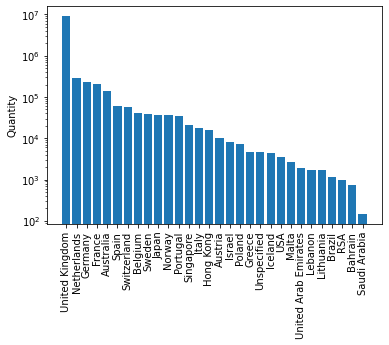

In [23]:
x = tot_price_by_country_pd['Country']
y = tot_price_by_country_pd['TotPrice']

plt.bar(x, y)
plt.yscale('log')
plt.ylabel('Quantity')
plt.xticks(rotation=90)
plt.show()

In [24]:
items_quantity = spark.sql("""SELECT Itemname, SUM(Quantity) as Quantity, SUM(TotPrice) as TotPrice FROM itemname_by_country GROUP BY Itemname""")
items_quantity_df = items_quantity.toPandas()

items_quantity_df = items_quantity_df.sort_values(by='Quantity', ascending=False)

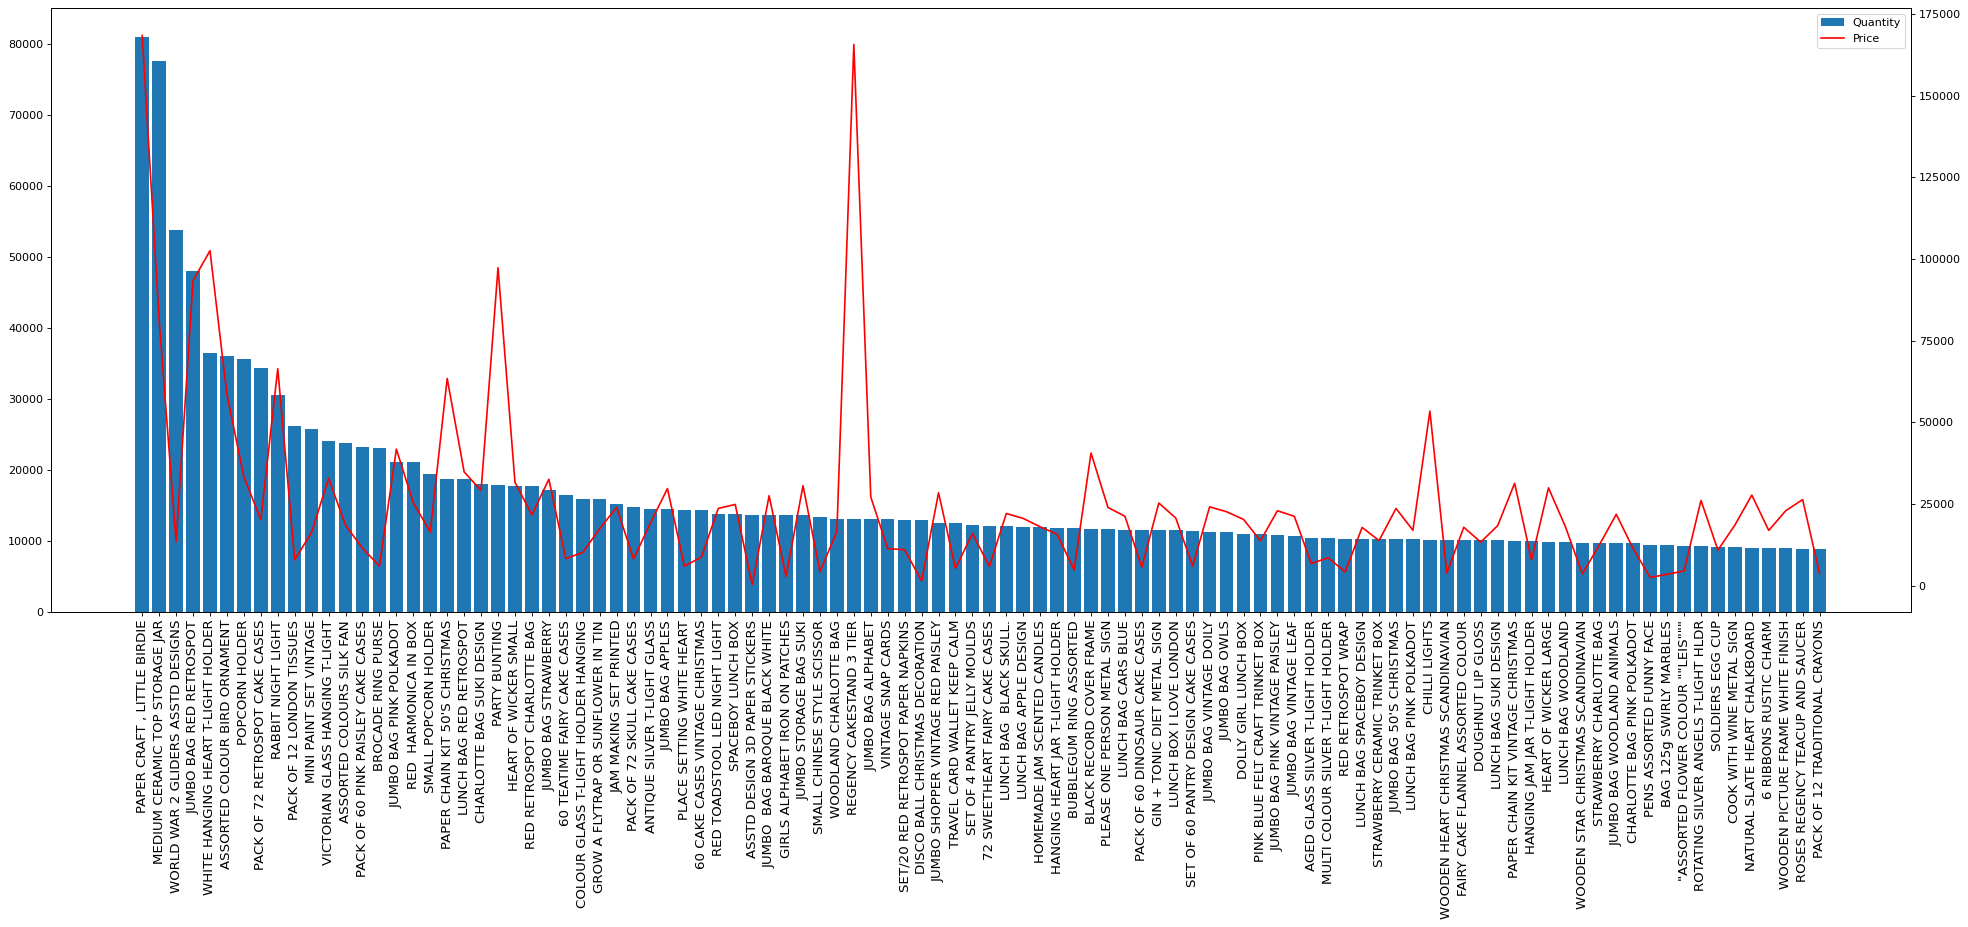

In [25]:
ntop = 100

x = items_quantity_df['Itemname'][:ntop]
quant = items_quantity_df['Quantity'][:ntop]
price = items_quantity_df['TotPrice'][:ntop]
plt.figure(figsize=(30, 10), dpi=80)

ax1 = plt.subplot()
l1 = ax1.bar(x, quant, label='Quantity')
plt.xticks(rotation=90, fontsize=12)

ax2 = ax1.twinx()
l2, = ax2.plot(x, price, label='Price', color='r')
plt.legend([l1, l2], ["Quantity", "Price"])
plt.show()

The above chart represents the quantity of items sold (bars) and the total gain for each item. We can see that the items which give the more gain are not always the ones which are sold in large quantity.

In [26]:
expense_per_customer = spark.sql("""SELECT CustomerID, Country, SUM(TotPrice) as TotPrice FROM df WHERE CustomerID <> 99999 GROUP BY CustomerID, Country""")
expense_per_customer_pd = expense_per_customer.toPandas()

In [27]:
expense_per_customer_pd.sort_values(by='TotPrice', ascending=False)

,CustomerID,Country,TotPrice
1534,14646,Netherlands,280206.02
2821,18102,United Kingdom,259657.30
3325,17450,United Kingdom,194550.79
1435,16446,United Kingdom,168472.50
364,12415,Australia,124914.53
...,...,...,...
3494,17956,United Kingdom,12.75
762,16454,United Kingdom,6.90
3216,14792,United Kingdom,6.20
4268,16738,United Kingdom,3.75


/home/hduser/.local/lib/python3.6/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


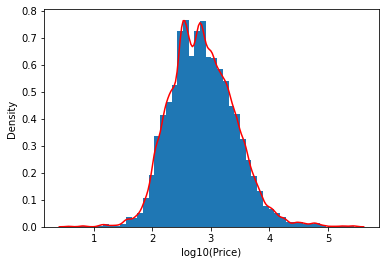

In [31]:
plt.hist(np.log10(expense_per_customer_pd['TotPrice'][expense_per_customer_pd['TotPrice']>0]), bins=50, density=True)
sns.kdeplot((np.log10(expense_per_customer_pd['TotPrice'][expense_per_customer_pd['TotPrice']>0])), bw=0.1, color='r')
plt.xlabel('log10(Price)')
plt.show()

We note that the distribution of the expenses per customer is symmetrical, with two peeks, in a log scale.

## Apriori Analysis

We append in a list all items belonging to the same buy (i.e. the same bill).

In [33]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer, CountVectorizer
from pyspark.sql.types import IntegerType

indexer = StringIndexer(inputCol="Itemname", outputCol="ItemnameIndex")

df_group = indexer.fit(df_market).transform(df_market)

#df_group = df_group.withColumn("Itemname", df_group["ItemnameIndex"].cast(IntegerType()))

df_group = df_group[['Country', 'BillNo', 'Itemname']].distinct()

df_group = df_group.groupBy('BillNo', 'Country').agg(collect_list('Itemname').alias('Itemname_vec'))

df_group.show()

+------+--------------+--------------------+
|BillNo|       Country|        Itemname_vec|
+------+--------------+--------------------+
|541216|United Kingdom|[RED RETROSPOT CH...|
|545000|United Kingdom|[POCKET BAG PINK ...|
|551547|United Kingdom|[RED RETROSPOT PL...|
|559039|United Kingdom|[RED LOVE HEART S...|
|562031|United Kingdom|[FIRST AID TIN, S...|
|566023|United Kingdom|[MAGIC DRAWING SL...|
|567671|United Kingdom|[MINI PAINT SET V...|
|570872|United Kingdom|[SNOWFLAKE PORTAB...|
|575930|United Kingdom|[PAPER POCKET TRA...|
|539865|United Kingdom|[VINYL RECORD FRA...|
|540506|United Kingdom|[SET OF 6 SPICE T...|
|544084|United Kingdom|[GLASS JAR MARMAL...|
|546899|United Kingdom|[JUMBO STORAGE BA...|
|550500|United Kingdom|[EASTER CRAFT 4 C...|
|551890|United Kingdom|[RETROSPOT PADDED...|
|556010|United Kingdom|[MEDIUM CHINESE S...|
|557306|United Kingdom|[RECYCLED ACAPULC...|
|572340|United Kingdom|[MIRROR MOSAIC T-...|
|574037|United Kingdom|[WRAP 50'S  CHRIS...|
|574319|Un

In [34]:
countries = []
for country in df_market[['Country']].distinct().collect():
    countries.append(country['Country'])

In [35]:
from pyspark.ml.fpm import FPGrowth
from time import time


minSupport=0.1
minConfidence=0.8
results = {}

#we take a subsample of countries
countries = ['Belgium', 'Germany', 'Italy', 'Netherlands', 'Portugal', 'Norway', 'Spain', 'Sweden', 'Australia' ]


for country in countries:

    print(country)
    fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
    model = fpGrowth.fit(df_group.filter(df_group['Country']==country))
    
    print('done')
    results[country] = model.associationRules

Belgium
done
Germany
done
Italy
done
Netherlands
done
Portugal
done
Norway
done
Spain
done
Sweden
done
Australia
done


In [36]:
from pyspark.sql.functions import lit
country = countries[0]
apriori = results[country].withColumn('country', lit(country))

for country in countries[1:5]:
    df_temp = results[country].withColumn('country', lit(country))
    apriori =  apriori.union(df_temp)

We computed the number of countries in which a certain association rule is present, as well as the mean lift and the minimum lift for all countries. From the following table we can see that there are rules with a significative lift (lift>2) shared by 3/2 countries.

In [43]:
apriori.createOrReplaceTempView("apriori")
rules = spark.sql("""SELECT antecedent, consequent, COUNT(DISTINCT country) as n_country , ROUND(AVG(lift), 3) as mean_lift, ROUND(MIN(lift), 3) as min_lift FROM apriori GROUP BY antecedent, consequent""")
rules.sort(col('n_country').desc(), col('mean_lift').desc()).show(30, truncate=False)

+-----------------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|antecedent                                                             |consequent                           |n_country|mean_lift|min_lift|
+-----------------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|[ROUND SNACK BOXES SET OF 4 FRUITS]                                    |[ROUND SNACK BOXES SET OF4 WOODLAND] |3        |2.954    |2.11    |
|[REGENCY CAKESTAND 3 TIER]                                             |[POSTAGE]                            |3        |1.292    |1.021   |
|[PLASTERS IN TIN CIRCUS PARADE]                                        |[PLASTERS IN TIN WOODLAND ANIMALS]   |2        |6.274    |6.214   |
|[ROUND SNACK BOXES SET OF 4 FRUITS, POSTAGE]                           |[ROUND SNACK BOXES SET OF4 WOODLAND] |2        |2.791    |2.211   |
|[ROUND SNACK

In [50]:
rules.limit(15).toPandas().head(15)

,antecedent,consequent,n_country,mean_lift,min_lift
0,"[WOODLAND CHARLOTTE BAG, DOLLY GIRL LUNCH BOX]",[SPACEBOY LUNCH BOX],1,3.393,3.393
1,[LUNCH BAG WOODLAND],[POSTAGE],1,1.021,1.021
2,[PLASTERS IN TIN WOODLAND ANIMALS],[ROUND SNACK BOXES SET OF4 WOODLAND],1,3.800,3.800
3,[RED RETROSPOT CHARLOTTE BAG],[ROUND SNACK BOXES SET OF4 WOODLAND],1,3.483,3.483
4,[JUMBO BAG RED RETROSPOT],[JUMBO BAG PINK VINTAGE PAISLEY],1,5.639,5.639
5,[PLASTERS IN TIN WOODLAND ANIMALS],[PLASTERS IN TIN VINTAGE PAISLEY],1,5.075,5.075
6,[TOY TIDY PINK POLKADOT],[RECYCLING BAG RETROSPOT],1,5.067,5.067
7,"[LUNCH BAG PINK POLKADOT, JUMBO BAG SCANDINAVI...",[JUMBO BAG PINK VINTAGE PAISLEY],1,6.444,6.444
8,[SCANDINAVIAN PAISLEY PICNIC BAG],[LUNCH BAG RED RETROSPOT],1,3.551,3.551
9,"[SET OF 20 KIDS COOKIE CUTTERS, RETROSPOT TEA ...",[GINGERBREAD MAN COOKIE CUTTER],1,9.500,9.500


<b>Now we apply the same algorithm to the whole dataset, considering a min support of 0.02 and a min confidence of 0.4.</b>

In [61]:
from pyspark.ml.fpm import FPGrowth
from time import time


minSupport=0.02
minConfidence=0.4

fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
model = fpGrowth.fit(df_group)
print('fitted')
results = model.associationRules
results.show()

fitted
+--------------------+--------------------+-------------------+------------------+
|          antecedent|          consequent|         confidence|              lift|
+--------------------+--------------------+-------------------+------------------+
|[PAPER CHAIN KIT ...|[PAPER CHAIN KIT ...| 0.6720098643649816|11.602899976590473|
|[JUMBO SHOPPER VI...|[JUMBO BAG RED RE...| 0.5797598627787307| 5.543391905008843|
|[JUMBO SHOPPER VI...|[JUMBO BAG PINK P...|0.40051457975986277| 6.526965509133684|
|[JUMBO SHOPPER VI...|[JUMBO STORAGE BA...|0.44596912521440824| 7.471307882942569|
|[LUNCH BAG SPACEB...|[LUNCH BAG  BLACK...| 0.4420226678291194| 6.923267737783866|
|[LUNCH BAG SPACEB...|[LUNCH BAG RED RE...|0.48212728857890147|  6.17442053218989|
|[LUNCH BAG SPACEB...|[LUNCH BAG CARS B...| 0.4167393199651264| 7.265327278720645|
|[LUNCH BAG SPACEB...|[LUNCH BAG WOODLAND]| 0.4149956408020924| 8.157309732300092|
|[JUMBO BAG ALPHABET]|[JUMBO BAG RED RE...|0.46440677966101696| 4.44043982393903

In [62]:
model.freqItemsets.show(10, False)

+-------------------------------------------------------------+----+
|items                                                        |freq|
+-------------------------------------------------------------+----+
|[JUMBO BAG VINTAGE CHRISTMAS]                                |470 |
|[WHITE HANGING HEART T-LIGHT HOLDER]                         |2202|
|[JUMBO BAG RED RETROSPOT]                                    |2064|
|[JUMBO BAG RED RETROSPOT, WHITE HANGING HEART T-LIGHT HOLDER]|442 |
|[NATURAL SLATE CHALKBOARD LARGE]                             |468 |
|[REGENCY CAKESTAND 3 TIER]                                   |1904|
|[SMALL HEART MEASURING SPOONS]                               |467 |
|[PARTY BUNTING]                                              |1656|
|[TOY TIDY PINK POLKADOT]                                     |466 |
|[LUNCH BAG RED RETROSPOT]                                    |1541|
+-------------------------------------------------------------+----+
only showing top 10 rows



In [65]:
model.associationRules.show() # Display generated association rules

+--------------------+--------------------+-------------------+------------------+
|          antecedent|          consequent|         confidence|              lift|
+--------------------+--------------------+-------------------+------------------+
|[PAPER CHAIN KIT ...|[PAPER CHAIN KIT ...| 0.6720098643649816|11.602899976590473|
|[JUMBO SHOPPER VI...|[JUMBO BAG RED RE...| 0.5797598627787307| 5.543391905008843|
|[JUMBO SHOPPER VI...|[JUMBO BAG PINK P...|0.40051457975986277| 6.526965509133684|
|[JUMBO SHOPPER VI...|[JUMBO STORAGE BA...|0.44596912521440824| 7.471307882942569|
|[LUNCH BAG SPACEB...|[LUNCH BAG  BLACK...| 0.4420226678291194| 6.923267737783866|
|[LUNCH BAG SPACEB...|[LUNCH BAG RED RE...|0.48212728857890147|  6.17442053218989|
|[LUNCH BAG SPACEB...|[LUNCH BAG CARS B...| 0.4167393199651264| 7.265327278720645|
|[LUNCH BAG SPACEB...|[LUNCH BAG WOODLAND]| 0.4149956408020924| 8.157309732300092|
|[JUMBO BAG ALPHABET]|[JUMBO BAG RED RE...|0.46440677966101696| 4.440439823939036|
|[WO

In [66]:
model.transform(df_group).show() # transform examines the input itemsagainst all the association rules and summarize the consequents as prediction

+------+--------------+--------------------+--------------------+
|BillNo|       Country|        Itemname_vec|          prediction|
+------+--------------+--------------------+--------------------+
|541216|United Kingdom|[RED RETROSPOT CH...|[LUNCH BAG RED RE...|
|545000|United Kingdom|[POCKET BAG PINK ...|[HEART OF WICKER ...|
|551547|United Kingdom|[RED RETROSPOT PL...|[PAPER CHAIN KIT ...|
|559039|United Kingdom|[RED LOVE HEART S...|   [JUMBO BAG PEARS]|
|562031|United Kingdom|[FIRST AID TIN, S...|[JUMBO BAG PINK P...|
|566023|United Kingdom|[MAGIC DRAWING SL...|                  []|
|567671|United Kingdom|[MINI PAINT SET V...|[JUMBO BAG PEARS,...|
|570872|United Kingdom|[SNOWFLAKE PORTAB...|[JUMBO BAG PINK P...|
|575930|United Kingdom|[PAPER POCKET TRA...|[LUNCH BAG  BLACK...|
|539865|United Kingdom|[VINYL RECORD FRA...|                  []|
|540506|United Kingdom|[SET OF 6 SPICE T...|[ALARM CLOCK BAKE...|
|544084|United Kingdom|[GLASS JAR MARMAL...|[HEART OF WICKER ...|
|546899|Un

In [69]:
for column in ['confidence', 'lift']:
    results = results.withColumn(column, round(results[column], 3))

results.sort(col('lift').desc()).show(20, truncate=False)

+------------------------------------------------------------------+-----------------------------------+----------+-----+
|antecedent                                                        |consequent                         |confidence|lift |
+------------------------------------------------------------------+-----------------------------------+----------+-----+
|[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER]|[PINK REGENCY TEACUP AND SAUCER]   |0.71      |18.89|
|[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER] |[GREEN REGENCY TEACUP AND SAUCER]  |0.9       |18.29|
|[GREEN REGENCY TEACUP AND SAUCER]                                 |[PINK REGENCY TEACUP AND SAUCER]   |0.62      |16.64|
|[PINK REGENCY TEACUP AND SAUCER]                                  |[GREEN REGENCY TEACUP AND SAUCER]  |0.82      |16.64|
|[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER] |[ROSES REGENCY TEACUP AND SAUCER]  |0.85      |16.58|
|[GARDENERS KNEELING PAD